In [61]:
import math
from typing import List, Tuple, Dict
import numpy as np

class BoxType:
    def __init__(self, d, l, h):
        self.d = d
        self.l = l
        self.h = h

class Container:
    def __init__(self, D, L, H, W):
        self.D = D
        self.H = H
        self.L = L
        self.W = W

class Layer:
    def __init__(self, box_type_idx, orientation, num_boxes):
        self.box_type_idx = box_type_idx
        self.orientation = orientation
        self.num_boxes = num_boxes
        self.height = None  # Inisialisasi height
        self.weight = 0.0   # Inisialisasi weight

class SolutionCandidate:
    def __init__(self, layers):
        self.layers = layers
        self.total_height = sum(layer.height for layer in layers)
        self.volume_utilization = 0.0
        self.weight_utilization = 0.0

def generate_layers(container, box_type):
    layers = {}
    for i, box in enumerate(box_type):
        for p in range(1,7):
            if p == 1:
                depth, length, height = box.d, box.l, box.h
            elif p == 2:
                depth, length, height = box.d, box.h, box.l
            elif p == 3:
                depth, length, height = box.l, box.d, box.h
            elif p == 4:
                depth, length, height = box.l, box.h, box.d
            elif p == 5:
                depth, length, height = box.h, box.d, box.l
            elif p == 6:
                depth, length, height = box.h, box.l, box.d
            
            n_depth = math.floor(container.D / depth)
            n_length = math.floor(container.L / length)

            num_boxes = n_depth * n_length
            
            if num_boxes > 0:
                layer = Layer(i, orientation=p, num_boxes=num_boxes)
                layer.height = height
                layers[(i, p)] = layer
    return layers

def generate_solution_candidates(container, box_types, layers):
    solutions = []
    t = len(box_types)

    for (i, p), layer in layers.items():
        if layer.height <= container.H:
            sol = SolutionCandidate([layer])
            sol.volume_utilization = (layer.num_boxes * box_types[i].d * box_types[i].l * box_types[i].h) / (container.D * container.L * container.H)
            solutions.append(sol)

    for (i1, p1), layer1 in layers.items():
        for (i2, p2), layer2 in layers.items():
            if i1 == i2 and p1 == p2:
                continue

            total_height = layer1.height + layer2.height
            if total_height <= container.H:
                sol = SolutionCandidate([layer1, layer2])
                vol1 = layer1.num_boxes * box_types[i1].d * box_types[i1].l * box_types[i1].h
                vol2 = layer2.num_boxes * box_types[i2].d * box_types[i2].l * box_types[i2].h
                sol.volume_utilization = (vol1 + vol2) / (container.D * container.L * container.H)
                solutions.append(sol)
    solutions.sort(key=lambda x: x.volume_utilization, reverse=True)
    return solutions

def pack_boxes(bin: Container, box_types: List[BoxType], solutions: List[SolutionCandidate], 
               num_boxes: List[int], box_weights: List[List[float]], 
               layers: Dict[Tuple[int, int], Layer]) -> Tuple[int, List[List[Layer]]]:
    """
    Packs boxes into bins using the best solution candidates.
    Args:
        bin (Container): The container to pack boxes into.
        box_types (List[BoxType]): List of box types with their dimensions and max weights.
        solutions (List[SolutionCandidate]): List of precomputed solution candidates.
        num_boxes (List[int]): Number of boxes available for each type.
        box_weights (List[List[float]]): Weights of the boxes for each type.
        layers (Dict[Tuple[int, int], Layer]): Precomputed layers for box types and orientations.
    Returns:
        Tuple[int, List[List[Layer]]]: Number of bins used and the packed bins with their layers.
    """
    # Initialize remaining boxes and weights (create deep copies)
    remaining_boxes = num_boxes.copy()
    remaining_weights = [weights.copy() for weights in box_weights]
    bins = []
    m = 0
    
    # Verification variables
    initial_counts = num_boxes.copy()
    packed_counts = [0] * len(box_types)
    
    while sum(remaining_boxes) > 0:
        # Sort remaining weights for each box type
        sorted_weights = []
        for i in range(len(box_types)):
            sorted_weights.append(sorted(remaining_weights[i], reverse=True))
        
        best_solution = None
        best_solution_idx = -1
        
        # Find the best solution candidate that fits in the bin
        for r, solution in enumerate(solutions):
            total_weight = 0.0
            feasible = True
            
            # Temporary variables for this solution attempt
            temp_packed = [0] * len(box_types)
            
            for layer in solution.layers:
                i = layer.box_type_idx
                if remaining_boxes[i] - temp_packed[i] < layer.num_boxes:
                    feasible = False
                    break
                
                half = layer.num_boxes // 2
                if half > 0:
                    total_weight += sum(sorted_weights[i][:half]) + sum(sorted_weights[i][-half:])
                else:
                    total_weight += sum(sorted_weights[i][:layer.num_boxes])
                
                temp_packed[i] += layer.num_boxes
            
            if feasible and total_weight <= bin.W:
                best_solution = solution
                best_solution_idx = r
                break
        
        if best_solution is None:
            # Fallback packing for remaining boxes
            bin_content = []
            for i in range(len(box_types)):
                if remaining_boxes[i] > 0:
                    for p in range(1, 7):
                        if (i, p) in layers:
                            num_to_pack = remaining_boxes[i]
                            new_layer = Layer(i, p, num_to_pack)
                            new_layer.height = layers[(i, p)].height
                            new_layer.weight = sum(sorted_weights[i][:num_to_pack])
                            
                            bin_content.append(new_layer)
                            packed_counts[i] += num_to_pack
                            remaining_boxes[i] = 0
                            sorted_weights[i] = []
                            break
            
            if bin_content:
                bins.append(bin_content)
                m += 1
                remaining_weights = sorted_weights
            break
        
        # Pack the best solution found
        bin_content = []
        for layer in best_solution.layers:
            i = layer.box_type_idx
            num_to_pack = layer.num_boxes
            new_layer = Layer(i, layer.orientation, num_to_pack)
            new_layer.height = layer.height
            
            half = num_to_pack // 2
            if half > 0:
                new_layer.weight = sum(sorted_weights[i][:half]) + sum(sorted_weights[i][-half:])
                del sorted_weights[i][:half]
                del sorted_weights[i][-(num_to_pack - half):]
            else:
                new_layer.weight = sum(sorted_weights[i][:num_to_pack])
                del sorted_weights[i][:num_to_pack]
            
            bin_content.append(new_layer)
            remaining_boxes[i] -= num_to_pack
            packed_counts[i] += num_to_pack
        
        bins.append(bin_content)
        m += 1
        remaining_weights = sorted_weights
    
    # Final verification
    for i in range(len(box_types)):
        if initial_counts[i] != packed_counts[i]:
            print(f"Error: Box type {i} initial={initial_counts[i]}, packed={packed_counts[i]}")
            return 0, []
    
    return m, bins

# panjang, lebar, tinggi, kapasitas kontainer
D = 243.8
L = 609.6
H = 259
bin = Container(D=D, L=L, H=H, W=6804)
    
box_types = [
    BoxType(d=0.15, l=0.3, h=0.2),
    BoxType(d=1.5, l=0.3, h=0.3),
    BoxType(d=0.4, l=0.4, h=1)
]

# Example problem instance
num_boxes = [200, 100, 50]  # Number of boxes for each type
box_weights = [
    [0.5] * 200,    # Weights for type 1 boxes (simplified)
    [2.0] * 100,    # Weights for type 2 boxes
    [1.0] * 50    # Weights for type 3 boxes
]

print("Running Stage 1: Generating layers...")
layers = generate_layers(bin, box_types)
print(f"Generated {len(layers)} layers")

print("\nRunning Stage 2: Generating solution candidates...")
solutions = generate_solution_candidates(bin, box_types, layers)
print(f"Generated {len(solutions)} solution candidates")
print(f"Best solution candidate has {solutions[0].volume_utilization*100:.1f}% volume utilization")

print("\nRunning Stage 3: Packing boxes into bins...")
num_bins, packed_bins = pack_boxes(bin, box_types, solutions, num_boxes, box_weights, layers)

print("\nPacking results:")
print(f"Total bins used: {num_bins}")
for i, bin_content in enumerate(packed_bins, 1):
    bin_weight = sum(layer.weight for layer in bin_content)
    bin_volume = sum(layer.num_boxes * (box_types[layer.box_type_idx].d * box_types[layer.box_type_idx].l * box_types[layer.box_type_idx].h)for layer in bin_content)
    bin_utilization = bin_volume / (bin.D * bin.L * bin.H)
    
    print(f"\nBin {i}:")
    print(f"- Weight: {bin_weight:.1f}/{bin.W} ({bin_weight/bin.W*100:.1f}%)")
    print(f"- Volume utilization: {bin_utilization*100:.1f}%")
    print("Layers:")
    for layer in bin_content:
        box_type = box_types[layer.box_type_idx]
        print(f"  - Type {layer.box_type_idx+1}, Orientation {layer.orientation}: {layer.num_boxes} boxes")
        print(f"    - Dimensions: {box_type.d}x{box_type.l}x{box_type.h}")
        print(f"    - Layer weight: {layer.weight:.1f}")
        
    

Running Stage 1: Generating layers...
Generated 18 layers

Running Stage 2: Generating solution candidates...
Generated 324 solution candidates
Best solution candidate has 1.2% volume utilization

Running Stage 3: Packing boxes into bins...

Packing results:
Total bins used: 1

Bin 1:
- Weight: 350.0/6804 (5.1%)
- Volume utilization: 0.0%
Layers:
  - Type 1, Orientation 1: 200 boxes
    - Dimensions: 0.15x0.3x0.2
    - Layer weight: 100.0
  - Type 2, Orientation 1: 100 boxes
    - Dimensions: 1.5x0.3x0.3
    - Layer weight: 200.0
  - Type 3, Orientation 1: 50 boxes
    - Dimensions: 0.4x0.4x1
    - Layer weight: 50.0


<img src="image.png">

In [62]:
D = 2.438
L = 6.096
H = 2.591
container = Container(D=D, L=L, H=H, W=6804)
box_types = [BoxType(d=0.15, l=0.3, h=0.2),BoxType(d=1.5, l=0.3, h=0.3),BoxType(d=0.4, l=0.4, h=1)] # ini sialiasai luas baranng

num_boxes = [200, 100, 50] # inisialisasi  banyak barang
box_weights = [
    [0.5] * 200,    # berat untuk barang jenis 1
    [2.0] * 100,    # berat untuk barang jenis 2
    [1.0] * 50    # berat untuk barang jenis 2
]

print("Running Stage 1: Generating layers...")
layers = generate_layers(container, box_types)
print(len(layers))
for (i,p), layer in layers.items():
    print(f"barang : {layer.box_type_idx} orientasi: {layer.orientation}, {layer.num_boxes} barang dapat memenuhi permukaan kontainer")

Running Stage 1: Generating layers...
18
barang : 0 orientasi: 1, 320 barang dapat memenuhi permukaan kontainer
barang : 0 orientasi: 2, 480 barang dapat memenuhi permukaan kontainer
barang : 0 orientasi: 3, 320 barang dapat memenuhi permukaan kontainer
barang : 0 orientasi: 4, 240 barang dapat memenuhi permukaan kontainer
barang : 0 orientasi: 5, 480 barang dapat memenuhi permukaan kontainer
barang : 0 orientasi: 6, 240 barang dapat memenuhi permukaan kontainer
barang : 1 orientasi: 1, 20 barang dapat memenuhi permukaan kontainer
barang : 1 orientasi: 2, 20 barang dapat memenuhi permukaan kontainer
barang : 1 orientasi: 3, 32 barang dapat memenuhi permukaan kontainer
barang : 1 orientasi: 4, 160 barang dapat memenuhi permukaan kontainer
barang : 1 orientasi: 5, 32 barang dapat memenuhi permukaan kontainer
barang : 1 orientasi: 6, 160 barang dapat memenuhi permukaan kontainer
barang : 2 orientasi: 1, 90 barang dapat memenuhi permukaan kontainer
barang : 2 orientasi: 2, 36 barang dapat 

In [63]:
print("\nRunning Stage 2: Generating solution candidates...\n")
solutions = generate_solution_candidates(container, box_types, layers)

for i, sol in enumerate(solutions, 1):
    print(f"solusi packing konatiner ke {i} berisi barang :")
    for layer in sol.layers:
        print(f"box tipe : {layer.box_type_idx} dengan orientasi ke {layer.orientation} dengan jumlah {layer.num_boxes}")
    print()


Running Stage 2: Generating solution candidates...

solusi packing konatiner ke 1 berisi barang :
box tipe : 1 dengan orientasi ke 4 dengan jumlah 160
box tipe : 2 dengan orientasi ke 1 dengan jumlah 90

solusi packing konatiner ke 2 berisi barang :
box tipe : 1 dengan orientasi ke 4 dengan jumlah 160
box tipe : 2 dengan orientasi ke 3 dengan jumlah 90

solusi packing konatiner ke 3 berisi barang :
box tipe : 1 dengan orientasi ke 6 dengan jumlah 160
box tipe : 2 dengan orientasi ke 1 dengan jumlah 90

solusi packing konatiner ke 4 berisi barang :
box tipe : 1 dengan orientasi ke 6 dengan jumlah 160
box tipe : 2 dengan orientasi ke 3 dengan jumlah 90

solusi packing konatiner ke 5 berisi barang :
box tipe : 2 dengan orientasi ke 1 dengan jumlah 90
box tipe : 1 dengan orientasi ke 4 dengan jumlah 160

solusi packing konatiner ke 6 berisi barang :
box tipe : 2 dengan orientasi ke 1 dengan jumlah 90
box tipe : 1 dengan orientasi ke 6 dengan jumlah 160

solusi packing konatiner ke 7 beris

In [64]:
num_bins, packed_bins = pack_boxes(container, box_types, solutions, num_boxes, box_weights, layers)

print("\nhasil solusinya:")
print(f"Kontainer yang digunakan: {num_bins}")
for i, bin_content in enumerate(packed_bins, 1):
    bin_weight = sum(layer.weight for layer in bin_content)
    bin_volume = sum(layer.num_boxes * (box_types[layer.box_type_idx].d * box_types[layer.box_type_idx].l * box_types[layer.box_type_idx].h)for layer in bin_content)
    bin_utilization = bin_volume / (bin.D * bin.L * bin.H)
    
    print(f"\nkontainer {i}:")
    print(f"- dengan berat muatan: {bin_weight:.1f}/{bin.W} ({bin_weight/bin.W*100:.1f}%)")
    print(f"- dengan Volume yang memenuhi: {bin_utilization*100:.5f}%")
    print("Barang:")
    for layer in bin_content:
        box_type = box_types[layer.box_type_idx]
        print(f"  - Barang Type {layer.box_type_idx+1}, Orientation {layer.orientation}: sebanyak {layer.num_boxes} ")
        print(f"    -  Dengen Dimensions: {box_type.d}x{box_type.l}x{box_type.h}")
        



hasil solusinya:
Kontainer yang digunakan: 3

kontainer 1:
- dengan berat muatan: 100.0/6804 (1.5%)
- dengan Volume yang memenuhi: 0.00003%
Barang:
  - Barang Type 2, Orientation 3: sebanyak 32 
    -  Dengen Dimensions: 1.5x0.3x0.3
  - Barang Type 3, Orientation 2: sebanyak 36 
    -  Dengen Dimensions: 0.4x0.4x1

kontainer 2:
- dengan berat muatan: 128.0/6804 (1.9%)
- dengan Volume yang memenuhi: 0.00002%
Barang:
  - Barang Type 2, Orientation 3: sebanyak 32 
    -  Dengen Dimensions: 1.5x0.3x0.3
  - Barang Type 2, Orientation 5: sebanyak 32 
    -  Dengen Dimensions: 1.5x0.3x0.3

kontainer 3:
- dengan berat muatan: 122.0/6804 (1.8%)
- dengan Volume yang memenuhi: 0.00001%
Barang:
  - Barang Type 1, Orientation 1: sebanyak 200 
    -  Dengen Dimensions: 0.15x0.3x0.2
  - Barang Type 2, Orientation 1: sebanyak 4 
    -  Dengen Dimensions: 1.5x0.3x0.3
  - Barang Type 3, Orientation 1: sebanyak 14 
    -  Dengen Dimensions: 0.4x0.4x1


In [66]:
32+36+32+32+4+14+200

350

Kontainer dibuat: Container(235x589x239, Items: 0)

Jumlah total item untuk dipacking: 20

Jumlah item yang berhasil ditempatkan: 20
Item yang berhasil ditempatkan:
  - 12: Pos(0,0,0), Dimensi Rotasi:(120, 120, 120)
  - 10: Pos(120,0,0), Dimensi Rotasi:(90, 90, 90)
  - 3: Pos(120,90,0), Dimensi Rotasi:(80, 120, 60)
  - 1: Pos(0,120,0), Dimensi Rotasi:(100, 100, 50)
  - 2: Pos(120,210,0), Dimensi Rotasi:(50, 50, 200)
  - 14: Pos(170,210,0), Dimensi Rotasi:(50, 200, 50)
  - 5: Pos(0,220,0), Dimensi Rotasi:(70, 70, 70)
  - 7: Pos(0,290,0), Dimensi Rotasi:(100, 50, 50)
  - 8: Pos(100,290,0), Dimensi Rotasi:(60, 60, 60)
  - 11: Pos(0,400,0), Dimensi Rotasi:(150, 30, 20)
  - 6: Pos(70,220,0), Dimensi Rotasi:(40, 40, 40)
  - 4: Pos(200,90,0), Dimensi Rotasi:(30, 30, 30)
  - 13: Pos(210,0,0), Dimensi Rotasi:(10, 10, 230)
  - 9: Pos(210,10,0), Dimensi Rotasi:(20, 20, 20)
  - 15: Pos(210,30,0), Dimensi Rotasi:(20, 20, 20)
  - 16: Pos(210,50,0), Dimensi Rotasi:(20, 20, 20)
  - 17: Pos(210,70,0), 

C:\Users\HP\AppData\Local\Temp\ipykernel_12960\3895427455.py:202: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(container.placed_items) + 1) # Untuk warna berbeda


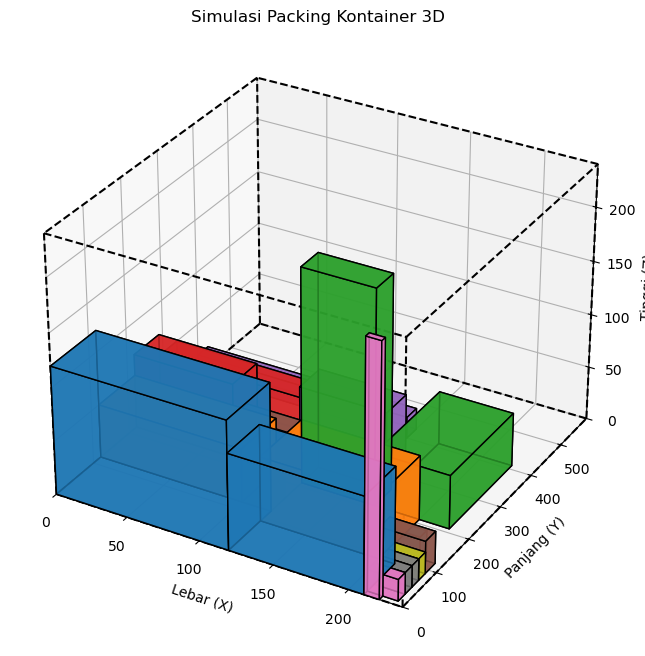

In [1]:
import operator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random

class Item:
    def __init__(self, id, width, length, height, weight=0):
        self.id = id
        self.width = width
        self.length = length
        self.height = height
        self.weight = weight
        self.x = 0
        self.y = 0
        self.z = 0
        self.placed = False
        self.rotated_dimensions = (width, length, height) # Dimensi saat ini setelah rotasi

    def __repr__(self):
        return f"Item(ID:{self.id}, Dim:{self.width}x{self.length}x{self.height}, Pos:{self.x},{self.y},{self.z}, Rotated:{self.rotated_dimensions})"

    def rotate(self, rotation_type):
        # 0: (w, l, h) - asli
        # 1: (w, h, l)
        # 2: (l, w, h)
        # 3: (l, h, w)
        # 4: (h, w, l)
        # 5: (h, l, w)

        dims = [self.width, self.length, self.height]
        if rotation_type == 0:
            self.rotated_dimensions = (dims[0], dims[1], dims[2])
        elif rotation_type == 1:
            self.rotated_dimensions = (dims[0], dims[2], dims[1])
        elif rotation_type == 2:
            self.rotated_dimensions = (dims[1], dims[0], dims[2])
        elif rotation_type == 3:
            self.rotated_dimensions = (dims[1], dims[2], dims[0])
        elif rotation_type == 4:
            self.rotated_dimensions = (dims[2], dims[0], dims[1])
        elif rotation_type == 5:
            self.rotated_dimensions = (dims[2], dims[1], dims[0])
        else:
            raise ValueError("Invalid rotation type")

        return self.rotated_dimensions

    @property
    def volume(self):
        return self.width * self.length * self.height

class Container:
    def __init__(self, width, length, height):
        self.width = width
        self.length = length
        self.height = height
        self.placed_items = []
        # Representasi ruang kosong: daftar tuples (x, y, z, w, l, h)
        self.free_spaces = [(0, 0, 0, width, length, height)]

    def __repr__(self):
        return f"Container({self.width}x{self.length}x{self.height}, Items: {len(self.placed_items)})"

    def can_place(self, item, x, y, z):
        # Periksa apakah item berada di dalam batas kontainer
        if (x + item.rotated_dimensions[0] > self.width or
            y + item.rotated_dimensions[1] > self.length or
            z + item.rotated_dimensions[2] > self.height):
            return False

        # Periksa tabrakan dengan item yang sudah ditempatkan
        for placed_item in self.placed_items:
            # Axis-Aligned Bounding Box (AABB) intersection check
            if not (x + item.rotated_dimensions[0] <= placed_item.x or
                    x >= placed_item.x + placed_item.rotated_dimensions[0] or
                    y + item.rotated_dimensions[1] <= placed_item.y or
                    y >= placed_item.y + placed_item.rotated_dimensions[1] or
                    z + item.rotated_dimensions[2] <= placed_item.z or
                    z >= placed_item.z + placed_item.rotated_dimensions[2]):
                return False # Terjadi tabrakan

        return True

    def place_item(self, item, x, y, z):
        item.x = x
        item.y = y
        item.z = z
        item.placed = True
        self.placed_items.append(item)

        # Update free_spaces
        new_free_spaces = []
        for fx, fy, fz, fw, fl, fh in self.free_spaces:
            # Jika ruang kosong saat ini bersinggungan dengan item
            if not (x + item.rotated_dimensions[0] <= fx or
                    x >= fx + fw or
                    y + item.rotated_dimensions[1] <= fy or
                    y >= fy + fl or
                    z + item.rotated_dimensions[2] <= fz or
                    z >= fz + fh):

                # Potong ruang kosong menjadi sub-ruang yang tidak ditempati item
                # Ini adalah bagian yang paling kompleks dan sering dioptimalkan
                # Untuk kesederhanaan, kita akan mencoba membagi di setiap dimensi

                # Ruang di depan item (relatif terhadap sumbu z)
                if fz < z:
                    new_free_spaces.append((fx, fy, fz, fw, fl, z - fz))
                # Ruang di belakang item (relatif terhadap sumbu z)
                if fz + fh > z + item.rotated_dimensions[2]:
                    new_free_spaces.append((fx, fy, z + item.rotated_dimensions[2], fw, fl, (fz + fh) - (z + item.rotated_dimensions[2])))

                # Ruang di kiri item (relatif terhadap sumbu y)
                if fy < y:
                    new_free_spaces.append((fx, fy, fz, fw, y - fy, fh))
                # Ruang di kanan item (relatif terhadap sumbu y)
                if fy + fl > y + item.rotated_dimensions[1]:
                    new_free_spaces.append((fx, fy + item.rotated_dimensions[1], fz, fw, (fy + fl) - (y + item.rotated_dimensions[1]), fh))

                # Ruang di bawah item (relatif terhadap sumbu x)
                if fx < x:
                    new_free_spaces.append((fx, fy, fz, x - fx, fl, fh))
                # Ruang di atas item (relatif terhadap sumbu x)
                if fx + fw > x + item.rotated_dimensions[0]:
                    new_free_spaces.append((x + item.rotated_dimensions[0], fy, fz, (fx + fw) - (x + item.rotated_dimensions[0]), fl, fh))

                # Hapus blok ruang kosong yang tumpang tindih
                # (Ini adalah pendekatan yang sangat sederhana, real world algo lebih kompleks)
            else:
                new_free_spaces.append((fx, fy, fz, fw, fl, fh))

        # Filter ruang kosong yang valid (dimensi positif)
        self.free_spaces = [(x,y,z,w,l,h) for x,y,z,w,l,h in new_free_spaces if w > 0 and l > 0 and h > 0]

        # Sort free spaces to prioritize bottom-left-front spots
        self.free_spaces.sort(key=lambda fs: (fs[2], fs[1], fs[0])) # Sort by Z, then Y, then X

def pack_container_ffd(container, items):
    # Urutkan item berdasarkan volume secara menurun (First Fit Decreasing)
    items_to_pack = sorted(items, key=operator.attrgetter('volume'), reverse=True)
    unpacked_items = []

    for item in items_to_pack:
        placed_current_item = False
        # Coba semua orientasi yang mungkin
        for rotation_type in range(6): # Ada 6 kemungkinan orientasi untuk balok
            item.rotate(rotation_type) # Atur dimensi item sesuai rotasi
            item_w, item_l, item_h = item.rotated_dimensions

            # Cari posisi kosong di antara free_spaces
            for fx, fy, fz, fw, fl, fh in container.free_spaces:
                if item_w <= fw and item_l <= fl and item_h <= fh:
                    # Ditemukan ruang kosong yang cukup
                    if container.can_place(item, fx, fy, fz):
                        container.place_item(item, fx, fy, fz)
                        placed_current_item = True
                        break # Item berhasil ditempatkan, lanjut ke item berikutnya
            if placed_current_item:
                break # Rotasi yang berhasil ditemukan

        if not placed_current_item:
            unpacked_items.append(item)
            # print(f"Tidak dapat menempatkan item {item.id} ({item.width}x{item.length}x{item.height})")

    return container, unpacked_items

# --- Fungsi Visualisasi 3D ---
def plot_container(container):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Gambar kontainer
    container_verts = [
        # Base
        [0, 0, 0], [container.width, 0, 0], [container.width, container.length, 0], [0, container.length, 0],
        # Top
        [0, 0, container.height], [container.width, 0, container.height], [container.width, container.length, container.height], [0, container.length, container.height]
    ]
    # Faces of the container (only edges or transparent faces)
    faces = [
        [container_verts[0], container_verts[1], container_verts[2], container_verts[3]], # Bottom
        [container_verts[4], container_verts[5], container_verts[6], container_verts[7]], # Top
        [container_verts[0], container_verts[1], container_verts[5], container_verts[4]], # Front
        [container_verts[2], container_verts[3], container_verts[7], container_verts[6]], # Back
        [container_verts[1], container_verts[2], container_verts[6], container_verts[5]], # Right
        [container_verts[0], container_verts[3], container_verts[7], container_verts[4]]  # Left
    ]

    # Plot container edges
    for i in range(4):
        ax.plot([container_verts[i][0], container_verts[(i+1)%4][0]],
                [container_verts[i][1], container_verts[(i+1)%4][1]],
                [container_verts[i][2], container_verts[(i+1)%4][2]], 'k--')
        ax.plot([container_verts[i+4][0], container_verts[(i+1)%4+4][0]],
                [container_verts[i+4][1], container_verts[(i+1)%4+4][1]],
                [container_verts[i+4][2], container_verts[(i+1)%4+4][2]], 'k--')
        ax.plot([container_verts[i][0], container_verts[i+4][0]],
                [container_verts[i][1], container_verts[i+4][1]],
                [container_verts[i][2], container_verts[i+4][2]], 'k--')

    # Plot item-item
    colors = plt.cm.get_cmap('tab10', len(container.placed_items) + 1) # Untuk warna berbeda

    for i, item in enumerate(container.placed_items):
        item_w, item_l, item_h = item.rotated_dimensions
        x, y, z = item.x, item.y, item.z

        # Define the 8 vertices of the box
        verts = [
            [x, y, z],
            [x + item_w, y, z],
            [x + item_w, y + item_l, z],
            [x, y + item_l, z],
            [x, y, z + item_h],
            [x + item_w, y, z + item_h],
            [x + item_w, y + item_l, z + item_h],
            [x, y + item_l, z + item_h]
        ]
        # Define the 6 faces of the box
        faces = [
            [verts[0], verts[1], verts[2], verts[3]], # Bottom
            [verts[4], verts[5], verts[6], verts[7]], # Top
            [verts[0], verts[1], verts[5], verts[4]], # Front
            [verts[2], verts[3], verts[7], verts[6]], # Back
            [verts[1], verts[2], verts[6], verts[5]], # Right
            [verts[0], verts[3], verts[7], verts[4]]  # Left
        ]
        poly = Poly3DCollection(faces, facecolor=colors(i), edgecolor='black', alpha=0.8)
        ax.add_collection3d(poly)

    ax.set_xlabel('Lebar (X)')
    ax.set_ylabel('Panjang (Y)')
    ax.set_zlabel('Tinggi (Z)')
    ax.set_xlim([0, container.width])
    ax.set_ylim([0, container.length])
    ax.set_zlim([0, container.height])
    ax.set_title('Simulasi Packing Kontainer 3D')
    plt.show()

# --- Contoh Penggunaan ---
if __name__ == "__main__":
    # Inisialisasi Kontainer (Misal: Kontainer standar 20 kaki)
    # Dimensi dalam cm
    # Kontainer 20ft: sekitar 589.8 cm (L) x 235.2 cm (W) x 239.3 cm (H)
    container_width = 235
    container_length = 589
    container_height = 239
    container = Container(container_width, container_length, container_height)
    print(f"Kontainer dibuat: {container}")

    # Buat beberapa item (balok)
    items_to_pack = [
        Item(1, 100, 100, 50),
        Item(2, 50, 50, 200),
        Item(3, 80, 120, 60),
        Item(4, 30, 30, 30),
        Item(5, 70, 70, 70),
        Item(6, 40, 40, 40),
        Item(7, 100, 50, 50),
        Item(8, 60, 60, 60),
        Item(9, 20, 20, 20),
        Item(10, 90, 90, 90),
        Item(11, 150, 30, 20),
        Item(12, 120, 120, 120),
        Item(13, 10, 10, 230), # Item tinggi
        Item(14, 50, 200, 50), # Item panjang
        Item(15, 20, 20, 20),
        Item(16, 20, 20, 20),
        Item(17, 20, 20, 20),
        Item(18, 20, 20, 20),
        Item(19, 20, 20, 20),
        Item(20, 20, 20, 20),
    ]

    # Tambahkan beberapa item duplikat untuk menguji
    # for i in range(21, 50):
    #     items_to_pack.append(Item(i, random.randint(20, 100), random.randint(20, 100), random.randint(20, 100)))

    print(f"\nJumlah total item untuk dipacking: {len(items_to_pack)}")

    # Jalankan algoritma packing
    packed_container, unpacked_items = pack_container_ffd(container, items_to_pack)

    print(f"\nJumlah item yang berhasil ditempatkan: {len(packed_container.placed_items)}")
    print("Item yang berhasil ditempatkan:")
    for item in packed_container.placed_items:
        print(f"  - {item.id}: Pos({item.x},{item.y},{item.z}), Dimensi Rotasi:{item.rotated_dimensions}")

    print(f"\nJumlah item yang tidak dapat ditempatkan: {len(unpacked_items)}")
    if unpacked_items:
        print("Item yang tidak dapat ditempatkan:")
        for item in unpacked_items:
            print(f"  - {item.id}: Dimensi Asli:{item.width}x{item.length}x{item.height}")

    # Hitung pemanfaatan volume
    total_item_volume = sum(item.volume for item in packed_container.placed_items)
    container_volume = container.width * container.length * container.height
    utilization_percentage = (total_item_volume / container_volume) * 100 if container_volume > 0 else 0

    print(f"\nPemanfaatan volume kontainer: {utilization_percentage:.2f}%")

    # Visualisasikan hasilnya
    plot_container(packed_container)

In [ ]:
import random
import time
import math
from typing import List, Dict, Tuple, Optional

class Item:
    def __init__(self, id: int, type_id: int, width: float, height: float, length: float, 
                 weight: float, profit: float, mandatory: bool, fragile: bool, heavy: bool):
        self.id = id
        self.type_id = type_id
        self.width = width
        self.height = height
        self.length = length
        self.weight = weight
        self.profit = profit
        self.mandatory = mandatory
        self.fragile = fragile
        self.heavy = heavy
        self.allowed_orientations = ['xyz', 'xzy', 'yxz', 'yzx', 'zxy', 'zyx']  # Default all orientations allowed
        
    def volume(self) -> float:
        return self.width * self.height * self.length
    
    def get_dimensions(self, orientation: str) -> Tuple[float, float, float]:
        """Return dimensions (width, height, length) for given orientation"""
        if orientation == 'xyz':
            return (self.width, self.height, self.length)
        elif orientation == 'xzy':
            return (self.width, self.length, self.height)
        elif orientation == 'yxz':
            return (self.height, self.width, self.length)
        elif orientation == 'yzx':
            return (self.height, self.length, self.width)
        elif orientation == 'zxy':
            return (self.length, self.width, self.height)
        elif orientation == 'zyx':
            return (self.length, self.height, self.width)
        else:
            raise ValueError(f"Invalid orientation: {orientation}")

class Container:
    def __init__(self, id: int, type_id: int, width: float, height: float, length: float, 
                 max_weight: float, cost: float, priority: int):
        self.id = id
        self.type_id = type_id
        self.width = width
        self.height = height
        self.length = length
        self.max_weight = max_weight
        self.cost = cost
        self.priority = priority
        self.items = []
        self.addition_points = [(0, 0, 0)]  # Initial addition point at origin
        
    def volume_capacity(self) -> float:
        return self.width * self.height * self.length
    
    def current_volume(self) -> float:
        return sum(item.volume() for item in self.items)
    
    def current_weight(self) -> float:
        return sum(item.weight for item in self.items)
    
    def utilization(self) -> float:
        vol_util = self.current_volume() / self.volume_capacity()
        weight_util = self.current_weight() / self.max_weight
        return max(vol_util, weight_util)

class CLPSolution:
    def __init__(self):
        self.containers = []
        self.unpacked_items = []
        self.total_profit = 0
        self.total_volume_packed = 0
        self.feasible = True
        self.moment = 0
        self.dispersion = 0
        self.distance = 0
    
    def add_container(self, container: Container):
        self.containers.append(container)
        self.total_profit -= container.cost  # Subtract cost when adding a new container
    
    def add_item_to_container(self, item: Item, container: Container):
        container.items.append(item)
        self.total_profit += item.profit
        self.total_volume_packed += item.volume()
    
    def remove_item_from_container(self, item: Item, container: Container):
        container.items.remove(item)
        self.total_profit -= item.profit
        self.total_volume_packed -= item.volume()
    
    def calculate_moment(self):
        """Calculate moment of item weights along the central z-axis"""
        total_moment = 0
        for container in self.containers:
            for item in container.items:
                # Assuming item position is stored as (x, y, z) in container coordinates
                # This is simplified - actual implementation would need position data
                item_moment = abs(item.x + item.width/2 - container.width/2) * item.weight
                total_moment += item_moment
        self.moment = total_moment
        return total_moment
    
    def calculate_dispersion(self):
        """Calculate dispersion of item types across containers"""
        type_counts = {}
        for container in self.containers:
            for item in container.items:
                if item.type_id not in type_counts:
                    type_counts[item.type_id] = 0
                type_counts[item.type_id] += 1
        
        dispersion = sum(count**2 for count in type_counts.values())
        self.dispersion = dispersion
        return dispersion

class LNSAlgorithm:
    def __init__(self, items: List[Item], containers: List[Container], 
                 item_compatibility: Dict[Tuple[int, int], bool],
                 container_compatibility: Dict[Tuple[int, int], bool],
                 time_limit: int = 300):
        self.items = items
        self.containers = containers
        self.item_compatibility = item_compatibility
        self.container_compatibility = container_compatibility
        self.time_limit = time_limit
        self.best_solution = None
        self.current_solution = None
        self.constructive_heuristic = "wall-building"  # Options: "wall-building", "layer-building", "column-building"
        self.optimize_balance = True
        self.require_front_support = False
    
    def run(self):
        start_time = time.time()
        
        # Step 1: Feasibility Check
        if not self.feasibility_check():
            print("Problem instance is infeasible")
            return None
        
        # Step 2: Sort Items
        sorted_items = self.sort_items()
        
        # Step 3: Constructive Heuristic
        self.current_solution = self.constructive_heuristic_phase(sorted_items)
        self.best_solution = self.current_solution
        
        # Step 4: Improvement Heuristic
        while time.time() - start_time < self.time_limit / 2:
            # Destroy and reconstruct solution
            self.improvement_heuristic_phase()
        
        # Further improvement focusing on individual containers
        remaining_time = max(0, self.time_limit - (time.time() - start_time))
        time_per_container = remaining_time / max(1, len(self.current_solution.containers))
        
        for container in self.current_solution.containers:
            container_start_time = time.time()
            while time.time() - container_start_time < time_per_container:
                self.improve_container(container)
        
        return self.best_solution
    
    def feasibility_check(self) -> bool:
        """Check if the problem instance is feasible"""
        # Check if all mandatory items fit in total container volume/weight
        total_item_volume = sum(item.volume() for item in self.items if item.mandatory)
        total_item_weight = sum(item.weight for item in self.items if item.mandatory)
        
        total_container_volume = sum(c.volume_capacity() for c in self.containers)
        total_container_weight = sum(c.max_weight for c in self.containers)
        
        if total_item_volume > total_container_volume or total_item_weight > total_container_weight:
            return False
        
        # Check if each item fits in at least one container
        for item in self.items:
            fits = False
            for container in self.containers:
                if (self.container_compatibility.get((item.type_id, container.type_id), True) and 
                    item.width <= container.width and 
                    item.height <= container.height and 
                    item.length <= container.length):
                    fits = True
                    break
            if not fits:
                return False
        
        return True
    
    def sort_items(self) -> List[Item]:
        """Sort items based on priority, size and profit"""
        # Separate mandatory and optional items
        mandatory_items = [item for item in self.items if item.mandatory]
        optional_items = [item for item in self.items if not item.mandatory]
        
        # Sort mandatory items by volume (largest first), then by weight
        mandatory_items.sort(key=lambda x: (-x.volume(), -x.weight))
        
        # Sort optional items by profit/volume ratio (highest first)
        optional_items.sort(key=lambda x: -x.profit/x.volume())
        
        return mandatory_items + optional_items
    
    def constructive_heuristic_phase(self, sorted_items: List[Item]) -> CLPSolution:
        """Create initial solution using constructive heuristic"""
        solution = CLPSolution()
        sorted_containers = self.sort_containers(solution)
        
        for container in sorted_containers:
            for item in sorted_items:
                if item in solution.unpacked_items:
                    self.add_item_to_container(item, container, solution)
            
            # Check if all mandatory items are packed
            solution.feasible = all(not item.mandatory or item not in solution.unpacked_items 
                                  for item in self.items)
            
            # Calculate solution metrics
            solution.calculate_dispersion()
            if self.optimize_balance:
                solution.calculate_moment()
        
        return solution
    
    def sort_containers(self, solution: CLPSolution) -> List[Container]:
        """Sort containers based on priority and utilization"""
        # First sort by priority (highest first)
        sorted_containers = sorted(self.containers, key=lambda x: -x.priority)
        
        # Then by utilization in current solution (if container is already used)
        container_utilization = {}
        for container in solution.containers:
            container_utilization[container.id] = container.utilization()
        
        sorted_containers.sort(key=lambda x: (-container_utilization.get(x.id, 0), 
                                            -x.cost/x.volume_capacity()))
        
        return sorted_containers
    
    def add_item_to_container(self, item: Item, container: Container, solution: CLPSolution) -> bool:
        """Attempt to add an item to a container considering constraints"""
        # Check basic feasibility
        if not self.container_compatibility.get((item.type_id, container.type_id), True):
            return False
        
        if item.volume() + container.current_volume() > container.volume_capacity():
            return False
        
        if item.weight + container.current_weight() > container.max_weight:
            return False
        
        # Check compatibility with items already in container
        for existing_item in container.items:
            if not self.item_compatibility.get((item.type_id, existing_item.type_id), True):
                return False
        
        # Try all allowed orientations
        for orientation in item.allowed_orientations:
            width, height, length = item.get_dimensions(orientation)
            
            # Try all addition points
            for point in container.addition_points:
                x, y, z = point
                
                # Check if item fits in container
                if (x + width > container.width or 
                    y + height > container.height or 
                    z + length > container.length):
                    continue
                
                # Check overlap with existing items
                overlaps = False
                for existing_item in container.items:
                    if self.check_overlap((x, y, z), (width, height, length), existing_item):
                        overlaps = True
                        break
                if overlaps:
                    continue
                
                # Check vertical support
                if y > 0:  # Not on container floor
                    support_area = self.calculate_support_area((x, y, z), (width, height, length), 
                                                             container.items)
                    if support_area < width * length:  # Needs full bottom support
                        continue
                
                # Check front-side support if required
                if self.require_front_support and z > 0:
                    front_support_area = self.calculate_front_support_area((x, y, z), 
                                                                         (width, height, length), 
                                                                         container.items)
                    if front_support_area < width * height:
                        continue
                
                # Found valid position - add item to container
                item.x, item.y, item.z = x, y, z
                item.orientation = orientation
                solution.add_item_to_container(item, container)
                
                # Update addition points
                container.addition_points.remove(point)
                if not item.fragile:
                    container.addition_points.extend([
                        (x + width, y, z),  # Right side
                        (x, y + height, z),  # Top side
                        (x, y, z + length)   # Back side
                    ])
                
                # Remove from unpacked items if it was there
                if item in solution.unpacked_items:
                    solution.unpacked_items.remove(item)
                
                return True
        
        # Couldn't find a valid position
        if item not in solution.unpacked_items:
            solution.unpacked_items.append(item)
        return False
    
    def check_overlap(self, pos1: Tuple[float, float, float], dim1: Tuple[float, float, float], 
                     item2: Item) -> bool:
        """Check if two items overlap"""
        x1, y1, z1 = pos1
        w1, h1, l1 = dim1
        
        x2, y2, z2 = item2.x, item2.y, item2.z
        w2, h2, l2 = item2.get_dimensions(item2.orientation)
        
        # Check if there's no overlap in any dimension
        if (x1 + w1 <= x2 or x2 + w2 <= x1 or
            y1 + h1 <= y2 or y2 + h2 <= y1 or
            z1 + l1 <= z2 or z2 + l2 <= z1):
            return False
        return True
    
    def calculate_support_area(self, pos: Tuple[float, float, float], 
                             dim: Tuple[float, float, float], 
                             items: List[Item]) -> float:
        """Calculate the support area from items below"""
        x, y, z = pos
        width, height, length = dim
        
        support_area = 0
        for item in items:
            if item.y + item.get_dimensions(item.orientation)[1] <= y:  # Item is below
                # Calculate overlapping area in x-z plane
                x_overlap = max(0, min(x + width, item.x + item.width) - max(x, item.x))
                z_overlap = max(0, min(z + length, item.z + item.length) - max(z, item.z))
                support_area += x_overlap * z_overlap
        
        return support_area
    
    def calculate_front_support_area(self, pos: Tuple[float, float, float], 
                                   dim: Tuple[float, float, float], 
                                   items: List[Item]) -> float:
        """Calculate the front support area from items in front"""
        x, y, z = pos
        width, height, length = dim
        
        support_area = 0
        for item in items:
            if item.z + item.get_dimensions(item.orientation)[2] <= z:  # Item is in front
                # Calculate overlapping area in x-y plane
                x_overlap = max(0, min(x + width, item.x + item.width) - max(x, item.x))
                y_overlap = max(0, min(y + height, item.y + item.height) - max(y, item.y))
                support_area += x_overlap * y_overlap
        
        return support_area
    
    def improvement_heuristic_phase(self):
        """Improve solution through destruction and reconstruction"""
        # With probability λ, start from best known solution
        if random.random() < 0.65:
            self.current_solution = self.copy_solution(self.best_solution)
        
        # Perturb the solution
        self.perturb_solution()
        
        # Destroy part of the solution
        self.destroy_solution()
        
        # Reconstruct the solution
        self.reconstruct_solution()
        
        # Update best solution if current is better
        if self.is_better_solution(self.current_solution, self.best_solution):
            self.best_solution = self.copy_solution(self.current_solution)
    
    def perturb_solution(self):
        """Randomly change item orientations and order"""
        # Perturb item orientations
        for item in self.items:
            if random.random() < 0.2:
                # Swap with another random orientation
                other_idx = random.randint(0, len(item.allowed_orientations)-1)
                item.allowed_orientations[0], item.allowed_orientations[other_idx] = (
                    item.allowed_orientations[other_idx], item.allowed_orientations[0])
        
        # Perturb item order (only affects unpacked items)
        if random.random() < 0.1 and len(self.current_solution.unpacked_items) > 1:
            i, j = random.sample(range(len(self.current_solution.unpacked_items)), 2)
            (self.current_solution.unpacked_items[i], 
             self.current_solution.unpacked_items[j]) = (
             self.current_solution.unpacked_items[j], 
             self.current_solution.unpacked_items[i])
    
    def destroy_solution(self):
        """Destroy part of the solution by emptying containers or removing items"""
        for container in list(self.current_solution.containers):
            if random.random() < (1 - container.utilization()) / 2:
                # Empty the container
                for item in list(container.items):
                    self.current_solution.remove_item_from_container(item, container)
                    self.current_solution.unpacked_items.append(item)
            else:
                # Remove random subset of items
                items_to_remove = []
                for item in container.items:
                    if not item.mandatory and random.random() < 0.3:
                        items_to_remove.append(item)
                
                if items_to_remove:
                    for item in items_to_remove:
                        self.current_solution.remove_item_from_container(item, container)
                        self.current_solution.unpacked_items.append(item)
                    
                    # Re-pack remaining items to ensure stability
                    remaining_items = container.items.copy()
                    container.items = []
                    container.addition_points = [(0, 0, 0)]
                    
                    for item in remaining_items:
                        self.add_item_to_container(item, container, self.current_solution)
    
    def reconstruct_solution(self):
        """Reconstruct solution by repacking unpacked items"""
        sorted_items = self.sort_items()
        sorted_containers = self.sort_containers(self.current_solution)
        
        # First try to pack into existing containers
        for container in sorted_containers:
            for item in sorted_items:
                if item in self.current_solution.unpacked_items:
                    self.add_item_to_container(item, container, self.current_solution)
        
        # Then try to pack into empty containers if needed
        for container in [c for c in self.containers if c not in self.current_solution.containers]:
            for item in sorted_items:
                if item in self.current_solution.unpacked_items:
                    if self.add_item_to_container(item, container, self.current_solution):
                        self.current_solution.add_container(container)
                        break  # Only add container if at least one item is packed
        
        # Update solution feasibility
        self.current_solution.feasible = all(
            not item.mandatory or item not in self.current_solution.unpacked_items 
            for item in self.items
        )
        
        # Update solution metrics
        self.current_solution.calculate_dispersion()
        if self.optimize_balance:
            self.current_solution.calculate_moment()
    
    def improve_container(self, container: Container):
        """Improve packing within a single container"""
        # Create a copy of the current solution
        temp_solution = self.copy_solution(self.current_solution)
        
        # Remove some items from the container
        items_to_remove = []
        for item in container.items:
            if random.random() < 0.3:  # Probability to remove an item
                items_to_remove.append(item)
        
        if not items_to_remove:
            return
        
        for item in items_to_remove:
            temp_solution.remove_item_from_container(item, container)
            temp_solution.unpacked_items.append(item)
        
        # Reset container addition points
        container.addition_points = [(0, 0, 0)]
        
        # Re-pack items in the container
        for item in [i for i in container.items if i not in items_to_remove]:
            self.add_item_to_container(item, container, temp_solution)
        
        # Try to repack removed items
        for item in items_to_remove:
            self.add_item_to_container(item, container, temp_solution)
        
        # Update solution metrics
        temp_solution.calculate_dispersion()
        if self.optimize_balance:
            temp_solution.calculate_moment()
        
        # Accept if better
        if self.is_better_solution(temp_solution, self.current_solution):
            self.current_solution = temp_solution
            if self.is_better_solution(self.current_solution, self.best_solution):
                self.best_solution = self.copy_solution(self.current_solution)
    
    def is_better_solution(self, solution1: CLPSolution, solution2: CLPSolution) -> bool:
        """Compare two solutions based on the lexicographical objectives"""
        if solution1.feasible and not solution2.feasible:
            return True
        if not solution1.feasible and not solution2.feasible:
            return solution1.total_volume_packed > solution2.total_volume_packed
        if solution1.feasible and solution2.feasible:
            if solution1.total_profit > solution2.total_profit:
                return True
            if solution1.total_profit == solution2.total_profit:
                if solution1.total_volume_packed > solution2.total_volume_packed:
                    return True
                if (solution1.total_volume_packed == solution2.total_volume_packed and 
                    self.optimize_balance):
                    if solution1.moment < solution2.moment:
                        return True
                    if solution1.moment == solution2.moment:
                        return solution1.distance < solution2.distance
        return False
    
    def copy_solution(self, solution: CLPSolution) -> CLPSolution:
        """Create a deep copy of a solution"""
        new_solution = CLPSolution()
        new_solution.unpacked_items = solution.unpacked_items.copy()
        new_solution.total_profit = solution.total_profit
        new_solution.total_volume_packed = solution.total_volume_packed
        new_solution.feasible = solution.feasible
        new_solution.moment = solution.moment
        new_solution.dispersion = solution.dispersion
        new_solution.distance = solution.distance
        
        # Create new container objects with copied items
        for container in solution.containers:
            new_container = Container(
                container.id, container.type_id, container.width, container.height,
                container.length, container.max_weight, container.cost, container.priority
            )
            new_container.items = container.items.copy()
            new_container.addition_points = container.addition_points.copy()
            new_solution.containers.append(new_container)
        
        return new_solution

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

def visualize_packing(solution):
    # Periksa jika tidak ada container dalam solusi
    if not solution.containers:
        print("Tidak ada container yang digunakan dalam solusi ini.")
        return
    
    # Periksa jika semua container kosong
    all_empty = all(len(container.items) == 0 for container in solution.containers)
    if all_empty:
        print("Semua container dalam solusi kosong (tidak ada item yang dimuat).")
        return

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Dapatkan semua tipe item yang ada
    item_types = set(item.type_id for container in solution.containers for item in container.items)
    
    # Jika ada item, buat color map
    if item_types:
        colors = plt.cm.jet(np.linspace(0, 1, len(item_types)))
        color_map = {type_id: colors[i] for i, type_id in enumerate(item_types)}
    else:
        color_map = {}
    
    # Hitung max_dim untuk setting batas plot
    container_dims = []
    for container in solution.containers:
        container_dims.extend([container.width, container.height, container.length])
        for item in container.items:
            width, height, length = item.get_dimensions(item.orientation)
            container_dims.extend([item.x + width, item.y + height, item.z + length])
    
    max_dim = max(container_dims) if container_dims else 10  # Default 10 jika tidak ada
    
    for container in solution.containers:
        # Gambar container (transparan)
        container_corners = [
            [0, 0, 0],
            [container.width, 0, 0],
            [container.width, container.height, 0],
            [0, container.height, 0],
            [0, 0, container.length],
            [container.width, 0, container.length],
            [container.width, container.height, container.length],
            [0, container.height, container.length]
        ]
        
        container_faces = [
            [container_corners[0], container_corners[1], container_corners[2], container_corners[3]],
            [container_corners[4], container_corners[5], container_corners[6], container_corners[7]],
            [container_corners[0], container_corners[1], container_corners[5], container_corners[4]],
            [container_corners[2], container_corners[3], container_corners[7], container_corners[6]],
            [container_corners[1], container_corners[2], container_corners[6], container_corners[5]],
            [container_corners[0], container_corners[3], container_corners[7], container_corners[4]]
        ]
        
        ax.add_collection3d(Poly3DCollection(container_faces, 
                                           facecolors='cyan', 
                                           linewidths=1, 
                                           edgecolors='blue',
                                           alpha=0.1))
        
        # Gambar semua item dalam container
        for item in container.items:
            width, height, length = item.get_dimensions(item.orientation)
            
            item_corners = [
                [item.x, item.y, item.z],
                [item.x + width, item.y, item.z],
                [item.x + width, item.y + height, item.z],
                [item.x, item.y + height, item.z],
                [item.x, item.y, item.z + length],
                [item.x + width, item.y, item.z + length],
                [item.x + width, item.y + height, item.z + length],
                [item.x, item.y + height, item.z + length]
            ]
            
            item_faces = [
                [item_corners[0], item_corners[1], item_corners[2], item_corners[3]],
                [item_corners[4], item_corners[5], item_corners[6], item_corners[7]],
                [item_corners[0], item_corners[1], item_corners[5], item_corners[4]],
                [item_corners[2], item_corners[3], item_corners[7], item_corners[6]],
                [item_corners[1], item_corners[2], item_corners[6], item_corners[5]],
                [item_corners[0], item_corners[3], item_corners[7], item_corners[4]]
            ]
            
            ax.add_collection3d(Poly3DCollection(item_faces, 
                                               facecolors=color_map.get(item.type_id, 'gray'), 
                                               linewidths=0.5, 
                                               edgecolors='k',
                                               alpha=0.7))
            
            # Label tipe item di tengah item
            ax.text(item.x + width/2, item.y + height/2, item.z + length/2, 
                   str(item.type_id), color='white', ha='center', va='center')
    
    # Atur batas plot dengan padding
    padding = max_dim * 0.2
    ax.set_xlim([0, max_dim + padding])
    ax.set_ylim([0, max_dim + padding])
    ax.set_zlim([0, max_dim + padding])
    
    ax.set_xlabel('Width (X)')
    ax.set_ylabel('Height (Y)')
    ax.set_zlabel('Length (Z)')
    
    # Buat legenda jika ada item
    if color_map:
        legend_elements = [plt.Rectangle((0,0), 1, 1, fc=color_map[type_id]) for type_id in color_map]
        ax.legend(legend_elements, [f'Type {type_id}' for type_id in color_map], 
                  loc='upper right', bbox_to_anchor=(1.2, 1))
    
    plt.title('3D Visualization of Container Loading Solution')
    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    # Create sample items
    items = [
        Item(1, 1, 10, 10, 10, 5, 100, True, False, False),
        Item(2, 1, 10, 10, 10, 5, 100, True, False, False),
        Item(3, 2, 20, 20, 20, 10, 200, True, False, False),
        Item(4, 3, 30, 30, 30, 15, 300, False, True, False),
        Item(5, 4, 40, 40, 40, 20, 400, False, False, True)
    ]
    
    # Create sample containers
    containers = [
        Container(1, 1, 120, 120, 120, 1000, 50, 1),
        Container(2, 1, 120, 120, 120, 1000, 50, 1),
        Container(3, 2, 150, 150, 150, 1500, 75, 2)
    ]
    
    # Define compatibility matrices (empty means all compatible)
    item_compatibility = {}  # All items compatible by default
    container_compatibility = {}  # All items compatible with all containers by default
    
    # Create and run LNS algorithm
    lns = LNSAlgorithm(items, containers, item_compatibility, container_compatibility, time_limit=60)
    solution = lns.run()
    # (Kode untuk membuat items, containers, dan menjalankan LNS sama seperti sebelumnya)
    
    # Setelah mendapatkan solusi, visualisasikan
    visualize_packing(solution)

Tidak ada container yang digunakan dalam solusi ini.


: 